In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from mod_opt.data_load import *

#### functions

In [2]:
import matplotlib.pyplot as plt
import ast
from sklearn.metrics import r2_score, mean_squared_error

def get_hyperparam_feat(df, index=0):
    '''
    Function to return hyperparameter config and selected features from dataframe of scores
    index =0 mean the hyperparameter for the highet r2_adj
    '''
    # Get the column names
    column_names = df.columns.tolist()

    # Find the index of 'r2_train'
    r2_train_index = column_names.index('num_features')

    # Select every column before 'r2_train'
    selected_columns = df.iloc[:, :r2_train_index]

    # Convert the DataFrame to a dictionary
    result_dict = selected_columns.to_dict('index')

    # Get the id of the best hyperparameter
    id = df.sort_values(by='r2_adj',ascending=False).index[index]

    # Get feature
    if type(df['selected_features'][id]) == str:
        df['selected_features'] = df['selected_features'].apply(ast.literal_eval)
    feat = df['selected_features'][id]
    return result_dict[id], feat

def plot_with_flight_num(predicted, actual, labels, title, plot_number=True, save_fig=None):

    # Extract the 'Flight' column
    flight_column = labels['Flight']
    plot_column = labels['Plot']

    # Get unique flight numbers
    unique_flights = flight_column.unique()

    # Define a color map to assign a unique color to each flight
    color_map = plt.get_cmap('turbo', len(unique_flights))
    #color_map = plt.get_cmap('Paired', len(unique_flights))

    # Sort unique_flights in ascending order
    unique_flights = np.sort(unique_flights)

    # Create scatter plots for each feature, distinguishing flights by color
    plt.figure(figsize=(8, 6))

    for i, flight_number in enumerate(unique_flights):
        mask = flight_column == flight_number
        # Check the starting characters of the flight number and change the marker accordingly
        if str(flight_number).startswith('2021'):
            marker = 'o'  # circle
        elif str(flight_number).startswith('2022'):
            marker = '^'  # triangle
        elif str(flight_number).startswith('2023'):
            marker = 'x'  # x

        plt.scatter(actual[mask], predicted[mask], s=100, alpha=1, label=f'{flight_number}', color=color_map(i/len(unique_flights)), marker=marker)

    if plot_number:
        # Add plot numbers as text labels
        for i,plot_num in enumerate(plot_column):
                plt.text(actual.iloc[i], predicted[i], f'{plot_num}', fontsize=10, ha='right')  
            
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--')
    plt.xlabel('Actual DS (%)', fontsize=18)
    plt.ylabel('Predicted DS (%)', fontsize=18)
    plt.title(title, fontsize=18)
    plt.legend(loc = 'upper left', ncol=3)
    plt.grid()
    plt.tick_params(axis='both', which='major', labelsize=16)  # Increase tick size
    plt.tight_layout()
    if save_fig:
        plt.savefig(save_fig)
    plt.show()

def model_evaluate2(model, feat, labels, title, plt_num=True, save_fig=None):
    print('Train score: ',model.score(X_train_norm[feat],y_train), ' RMSE:',mean_squared_error(y_train, model.predict(X_train_norm[feat]), squared=False))
    print('Validation score: ',model.score(X_val_norm[feat],y_val), ' RMSE:',mean_squared_error(y_val, model.predict(X_val_norm[feat]), squared=False))
    print('Test score: ',model.score(X_test_norm[feat],y_test), ' RMSE:',mean_squared_error(y_test, model.predict(X_test_norm[feat]), squared=False))

    plot_with_flight_num(model.predict(X_test_norm[feat])*100,y_test*100,labels, title=title, plot_number=plt_num,save_fig=save_fig)

def evaluate_model_by_flight_combined(model, feat, X, y, labels_):
    # This function evaluates a given model's performance by flight group. It calculates R-squared 
    # and RMSE metrics for the combined dataset for each unique flight group in the dataset. 
    # The function requires the model, features (feat), and labels containing flight information. 
    # It returns a DataFrame with flight groups as the index and the evaluation metrics for each dataset.
    
    labels = labels_.copy()  # Copy labels to avoid modifying the original DataFrame
    results = []  # Initialize results list
    labels['FlightGroup'] = labels['Flight'].astype(str).str[:4]  # Extract the first four digits of the 'Flight' column
    unique_flight_groups = labels['FlightGroup'].unique()  # Get unique flight groups from labels

    for flight_group in unique_flight_groups:  # Iterate over each unique flight group
        # Filter datasets for the current flight group
        mask = labels['FlightGroup'] == flight_group
        X_flt, y_flt = X[mask], y[mask]

        # Calculate scores and RMSE for the combined dataset
        r2_combined = model.score(X_flt[feat], y_flt)
        rmse_combined = np.sqrt(mean_squared_error(y_flt, model.predict(X_flt[feat])))

        # Append the results
        results.append({
            'FlightGroup': flight_group,
            '$R^2$': r2_combined,
            'RMSE (%)': rmse_combined
        })

    # Convert results list to DataFrame
    results_df = pd.DataFrame(results)
    results_df.set_index('FlightGroup', inplace=True)
    
    return results_df


In [3]:
def evaluate_model_by_flight_combined(model, feat, X, y, labels_):
    # This function evaluates a given model's performance by flight group. It calculates R-squared 
    # and RMSE metrics for the combined dataset for each unique flight group in the dataset. 
    # The function requires the model, features (feat), and labels containing flight information. 
    # It returns a DataFrame with flight groups as the index and the evaluation metrics for each dataset.
    
    labels = labels_.copy()  # Copy labels to avoid modifying the original DataFrame
    results = []  # Initialize results list
    
    # Create a new column to group 2021 and 2022 together, and keep 2023 separate
    labels['FlightGroup'] = labels['Flight'].astype(str).str[:4].replace({'2021': '2021-2022', '2022': '2021-2022'})
    
    unique_flight_groups = labels['FlightGroup'].unique()  # Get unique flight groups from labels

    for flight_group in unique_flight_groups:  # Iterate over each unique flight group
        # Filter datasets for the current flight group
        mask = labels['FlightGroup'] == flight_group
        X_flt, y_flt = X[mask], y[mask]

        # Calculate scores and RMSE for the combined dataset
        r2_combined = model.score(X_flt[feat], y_flt)
        rmse_combined = np.sqrt(mean_squared_error(y_flt, model.predict(X_flt[feat])))

        # Append the results
        results.append({
            'FlightGroup': flight_group,
            '$R^2$': r2_combined,
            'RMSE (%)': rmse_combined
        })

    # Convert results list to DataFrame
    results_df = pd.DataFrame(results)
    results_df.set_index('FlightGroup', inplace=True)
    
    return results_df

## RF

c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train score:  0.8936308653091674  RMSE: 0.06923516415670579
Validation score:  0.870722343123187  RMSE: 0.08094402100116532
Test score:  0.8212898350870208  RMSE: 0.09307135641089022


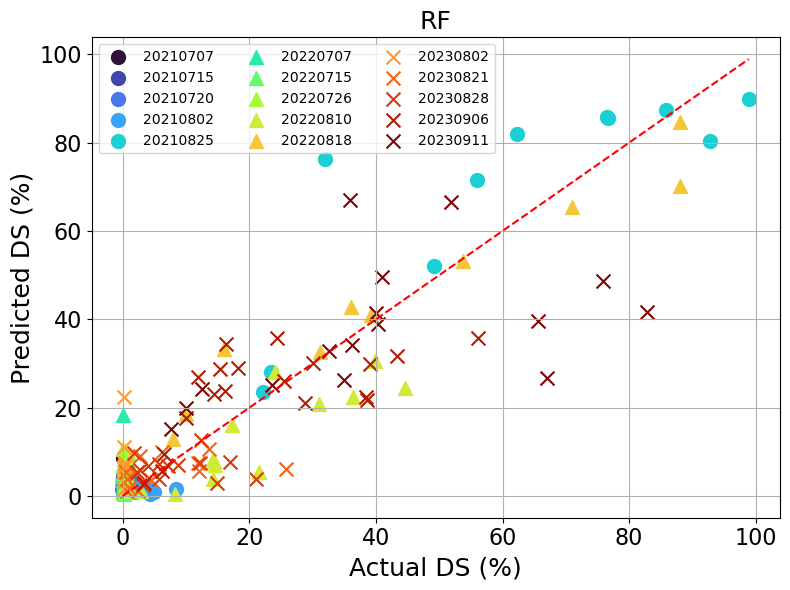

In [3]:
from sklearn.ensemble import RandomForestRegressor

result_rf = pd.read_csv('mod_opt/model_scores/rf_scores_mfs.csv',index_col=0,header=0)
hyperparameters, feat = get_hyperparam_feat(result_rf, index=0)

model = RandomForestRegressor(**hyperparameters).fit(X_train_norm[feat],y_train)
model_evaluate2(model, feat, labels_test, title='RF', plt_num=False)#, save_fig='figures/RF_test.png')

In [22]:
print(evaluate_model_by_flight_combined(model, feat, X_train_norm, y_train, labels_train))
print(evaluate_model_by_flight_combined(model, feat, X_test_norm, y_test, labels_test))

                $R^2$  RMSE (%)
FlightGroup                    
2021-2022    0.939703  0.060192
2023         0.733491  0.080127
                $R^2$  RMSE (%)
FlightGroup                    
2023         0.613566  0.122270
2021-2022    0.901458  0.071822


## XGBoost

c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train score:  0.9250440377961859  RMSE: 0.05811951812777224
Validation score:  0.8856709010695105  RMSE: 0.0761204643777621
Test score:  0.8078434381045663  RMSE: 0.09650926882920632


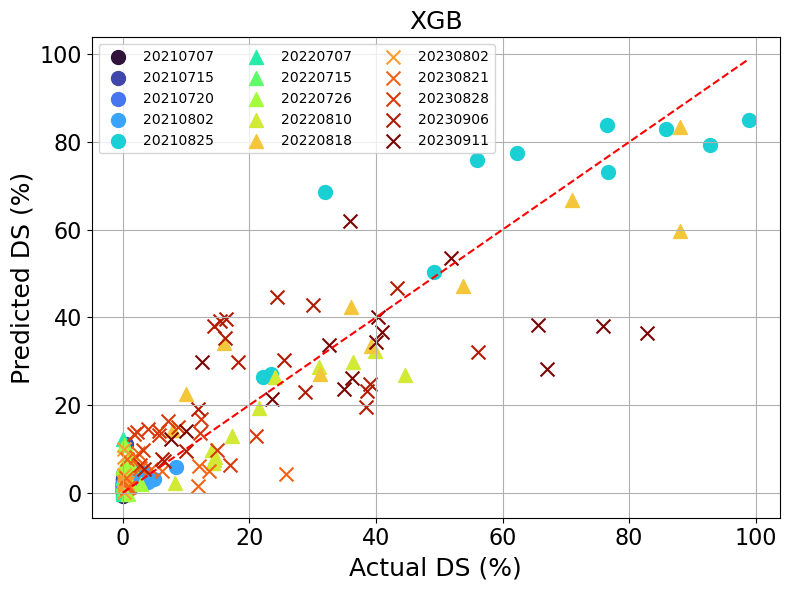

In [23]:
import xgboost as xgb

result_xgb = pd.read_csv('mod_opt/model_scores/xgb_scores_mfs.csv',index_col=0,header=0)
hyperparameters, feat = get_hyperparam_feat(result_xgb, index=0)

model = xgb.XGBRegressor(**hyperparameters).fit(X_train_norm[feat],y_train)
model_evaluate2(model, feat,labels_test, title='XGB', plt_num=False)#, save_fig='figures/XGB_test.png')

In [24]:
print(evaluate_model_by_flight_combined(model, feat, X_train_norm, y_train, labels_train))
print(evaluate_model_by_flight_combined(model, feat, X_test_norm, y_test, labels_test))

                $R^2$  RMSE (%)
FlightGroup                    
2021-2022    0.966615  0.044789
2023         0.780629  0.072696
                $R^2$  RMSE (%)
FlightGroup                    
2023         0.526771  0.135307
2021-2022    0.917814  0.065591


## SVR

c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train score:  0.8750461438037025  RMSE: 0.0750401588679102
Validation score:  0.8067473699418808  RMSE: 0.09896593800694084
Test score:  0.7822844651365088  RMSE: 0.10272735943867563


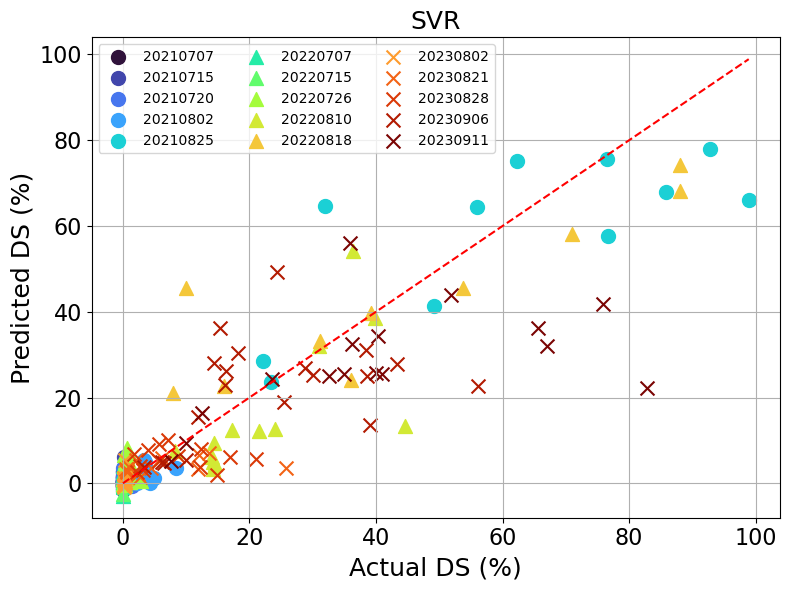

In [25]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

result_svr = pd.read_csv('mod_opt/model_scores/svr_scores_cfs.csv',index_col=0,header=0)
hyperparameters, feat = get_hyperparam_feat(result_svr, index=0)

model = SVR(**hyperparameters).fit(X_train_norm[feat],y_train)
model_evaluate2(model, feat, labels_test, title='SVR', plt_num=False)#, save_fig='figures/SVR_test.png')

In [26]:
print(evaluate_model_by_flight_combined(model, feat, X_train_norm, y_train, labels_train))
print(evaluate_model_by_flight_combined(model, feat, X_test_norm, y_test, labels_test))

                $R^2$  RMSE (%)
FlightGroup                    
2021-2022    0.954011  0.052568
2023         0.600796  0.098066
                $R^2$  RMSE (%)
FlightGroup                    
2023         0.528357  0.135080
2021-2022    0.880306  0.079156


## PLSR

c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train score:  0.7631890713712791  RMSE: 0.10330462928085933
Validation score:  0.827123630166636  RMSE: 0.09360323443318556
Test score:  0.7865165505555299  RMSE: 0.1017240215621344


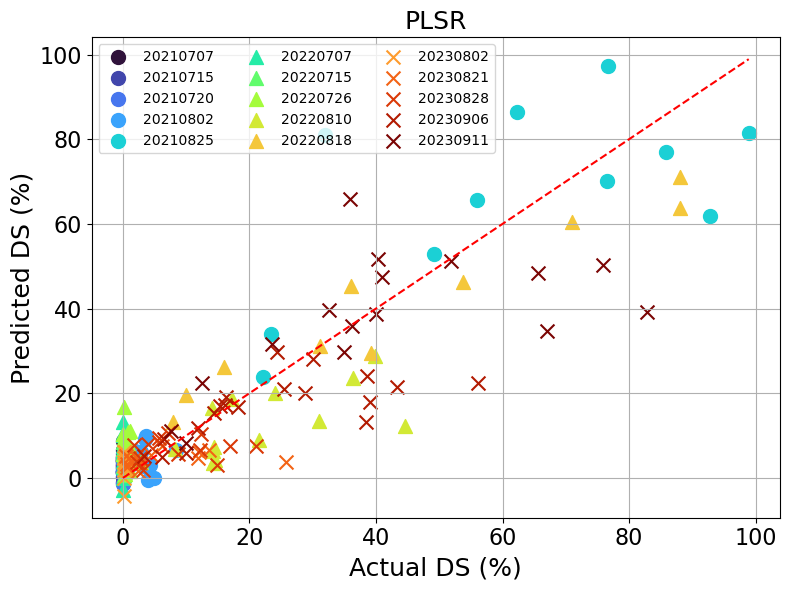

In [27]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error

result_plsr = pd.read_csv('mod_opt/model_scores/plsr_scores_cfs.csv',index_col=0,header=0)
hyperparameters, feat = get_hyperparam_feat(result_plsr, index=0)
hyperparameters ={'n_components': 5} # to avoid n_component > n_feature error
model = PLSRegression(**hyperparameters).fit(X_train_norm[feat],y_train)
model_evaluate2(model, feat, labels_test, title='PLSR', plt_num=False)#, save_fig='figures/PLSR_test.png')

In [28]:
print(evaluate_model_by_flight_combined(model, feat, X_train_norm, y_train, labels_train))
print(evaluate_model_by_flight_combined(model, feat, X_test_norm, y_test, labels_test))

                $R^2$  RMSE (%)
FlightGroup                    
2021-2022    0.841911  0.097464
2023         0.489344  0.110913
                $R^2$  RMSE (%)
FlightGroup                    
2023         0.656290  0.115313
2021-2022    0.833721  0.093296


## MLP

c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train score:  0.8566425006092733  RMSE: 0.0803765056783278
Validation score:  0.8540943310228567  RMSE: 0.08599221224823358
Test score:  0.8140402750111061  RMSE: 0.09494035759065081


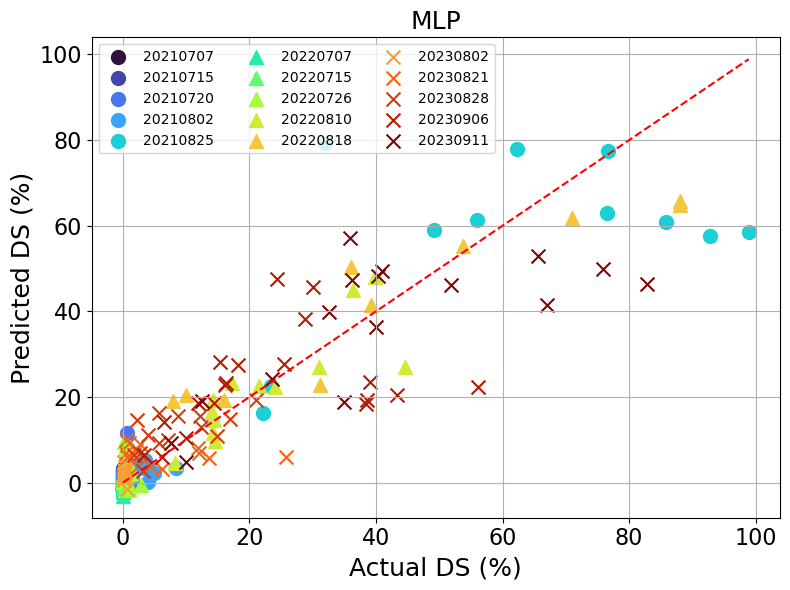

In [11]:
from sklearn.neural_network import MLPRegressor

result_mlp = pd.read_csv('mod_opt/model_scores/mlp_scores_micorfs.csv',index_col=0,header=0)
hyperparameters, feat = get_hyperparam_feat(result_mlp, index=0)

# Convert hidden_layer_sizes to a tuple if it is a string
if isinstance(hyperparameters['hidden_layer_sizes'], str):
	hyperparameters['hidden_layer_sizes'] = ast.literal_eval(hyperparameters['hidden_layer_sizes'])

model = MLPRegressor(**hyperparameters).fit(X_train_norm[feat],y_train)
model_evaluate2(model, feat, labels_test, title='MLP', plt_num=False)#, save_fig='figures/mlp_test.png')

In [8]:
hyperparameters

{'hidden_layer_sizes': (150, 100, 50, 25, 10, 5),
 'activation': 'relu',
 'solver': 'adam',
 'alpha': 0.05,
 'learning_rate': 'adaptive',
 'max_iter': 200,
 'random_state': 42}

In [14]:
feat

['rdvi_skewness',
 'mcariosavi_q3',
 'mcariosavi_skewness',
 'ref_mean_1',
 'ref_q1_2',
 'ref_q3_3',
 'ref_skewness_1',
 'ref_skewness_3',
 'tex_dis_cv_1',
 'tex_mean_q3_1',
 'tex_mean_skewness_4',
 'tex_var_kurtosis_4',
 'tex_cor_cv_3',
 'tex_cor_cv_4',
 'tex_cor_q3_4']

In [11]:
print(evaluate_model_by_flight_combined(model, feat, X_train_norm, y_train, labels_train))
print(evaluate_model_by_flight_combined(model, feat, X_test_norm, y_test, labels_test))

                $R^2$  RMSE (%)
FlightGroup                    
2021-2022    0.907972  0.074362
2023         0.678130  0.088056
                $R^2$  RMSE (%)
FlightGroup                    
2023         0.670500  0.112904
2021-2022    0.867556  0.083265
